In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random
import cv2
import warnings
import math
from tabulate import tabulate
sys.path.append('../')

In [2]:
import scipy.io as sio
from load_mat import load_mat
from drawLinedrawing import drawLinedrawing

In [3]:
filename = '../dataSets/TorontoScenes/cities_vecLD.mat'
# Given the above keys, we access 77th row of the data
data_keys = {'originalImage','imsize', 'lineMethod', 'numContours',                
            'contours', 'orientations', 'lengths',   'contourLengths',             
            'curvatures', 'junctions', 'parallelism',  'parallelismMeans',           
            'parallelism_allX', 'parallelism_allY','parallelism_allScores', 
            'parallelismBins', 'parallelismHistograms', 'parallelismNormHistograms',  
            'parallelismSumHistogram', 'parallelismNormSumHistogram',
            'separation', 'separationMeans', 'separation_allX',  'separation_allY',            
            'separation_allScores', 'separationBins',             
            'separationHistograms', 'separationNormHistograms',   
            'separationSumHistogram', 'separationNormSumHistogram', 
            'mirror', 'mirrorMeans', 'mirror_allX', 'mirror_allY',                
            'mirror_allScores', 'mirrorBins', 'mirrorHistograms', 
            'mirrorNormHistograms', 'mirrorSumHistogram', 'mirrorNormSumHistogram'}

In [4]:
data = load_mat(filename)
print(data['vecLD']['contourLengths'][0][0][76])
print(data['vecLD']['contours'][0][8].shape)
print(data['vecLD']['contourLengths'][0][1].shape)

[68.22431321]
(1, 1083)
(595, 1)


In [5]:
cute = {}
# Assign the data to the dictionary and define them with empty value
for key in data_keys:
    cute[key] = data['vecLD'][key][0][76]
print(cute['contours'][0].shape)

(476,)


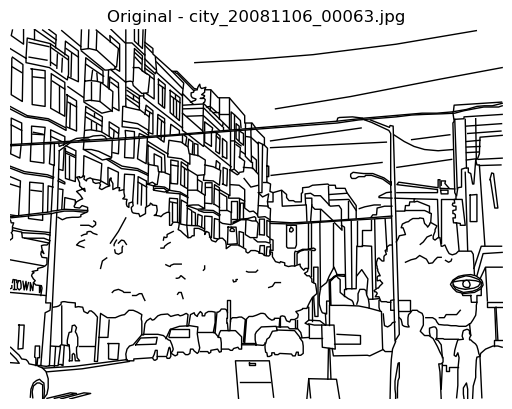

In [6]:
drawLinedrawing(cute)

In [7]:
from computeOrientation import computeOrientation
from computeLength import computeLength
from computeCurvature import computeCurvature
# Add junctions
# from computeJunctions_FIX import computeJunctions
from computeContourProperties import computeContourProperties

In [8]:
# To be worked on
def computeJunctions(vecLD):
    """
    Computes all junctions between contours in the vectorized line drawing vecLD.

    Args:
        vecLD (LineDrawingStructure): The vectorized line drawing data structure.

    Returns:
        LineDrawingStructure: A vector LD of structs with junction information added.

    Output Structure:
        Each junction consists of the following information:
        - contourIDs (list): Vector of IDs of contours involved in the junction.
        - segmentIDs (list): Vector of IDs of the segments within these contours.
        - position (list): Location of the junction [x, y].
        - angle (float): Smallest angle of the junction.
        - type (str): Based on the largest angle a, one of: 'T', 'Y', 'X', 'Arrow', 'Star'.

    -----------------------------------------------------
    This function is part of the Mid Level Vision Toolbox:
    http://www.mlvtoolbox.org

    Copyright Dirk Bernhardt-Walther
    University of Toronto, Toronto, Ontario, Canada, 2022

    Contact: dirk.walther@gmail.com
    -----------------------------------------------------
    """
    if not hasattr(vecLD, 'orientations'):
        vecLD = computeOrientation(vecLD)
    if not hasattr(vecLD, 'lengths'):
        vecLD = computeLength(vecLD)
    
    # 3 Step Process

    # 1. Detect any intersections between line segments
    jcts = detectIntersections(vecLD) # Need to write this function

    # 2. Merge Junctions that the close by
    jcts = cleanupJunctions(jcts) # Need to write this function

    # 3. Measure angles and classify junctions
    vecLD['junctions'] = computeJunctionAnglesTypes(jcts, vecLD)    # Need to write this function

    return vecLD


### Draw functions

In [9]:
from drawJunctions import drawJunctions
from drawLinedrawingProperty import drawLinedrawingProperty
from computeColorIndex import computeColorIndex
from drawMATproperty import drawMATproperty
from drawThisProperty import drawThisProperty
from drawAllProperties import drawAllProperties

### Testing

In [13]:
temp_ld = computeContourProperties(cute, ['orientation', 'curvature'])

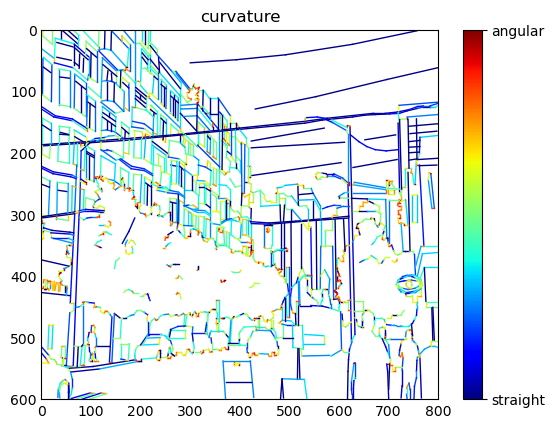

In [14]:
drawAllProperties(temp_ld, 'subplot', ['curvature'])

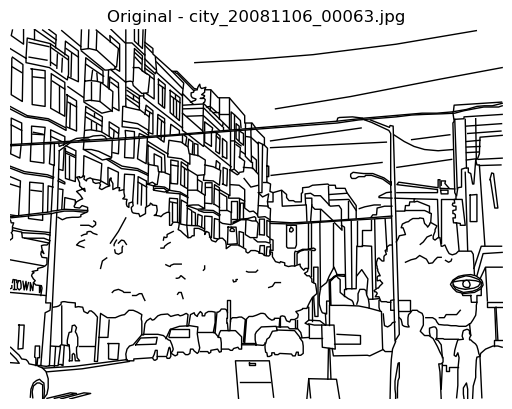

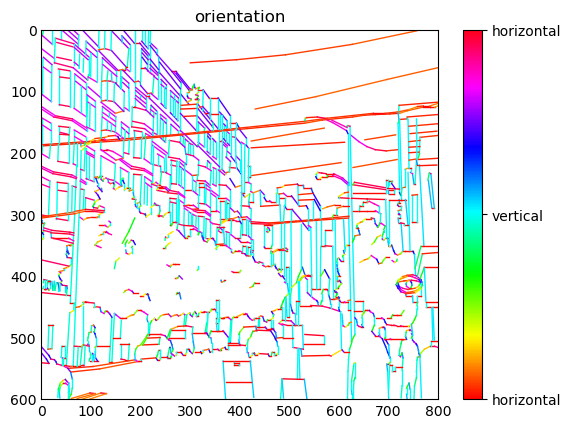

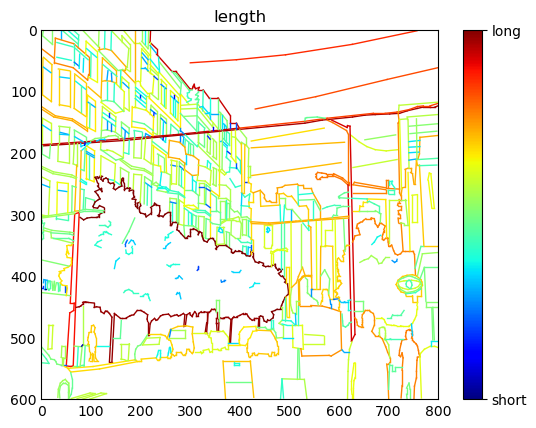

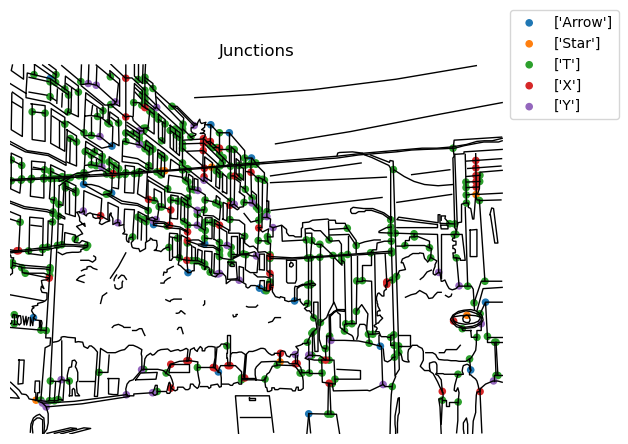

mirror


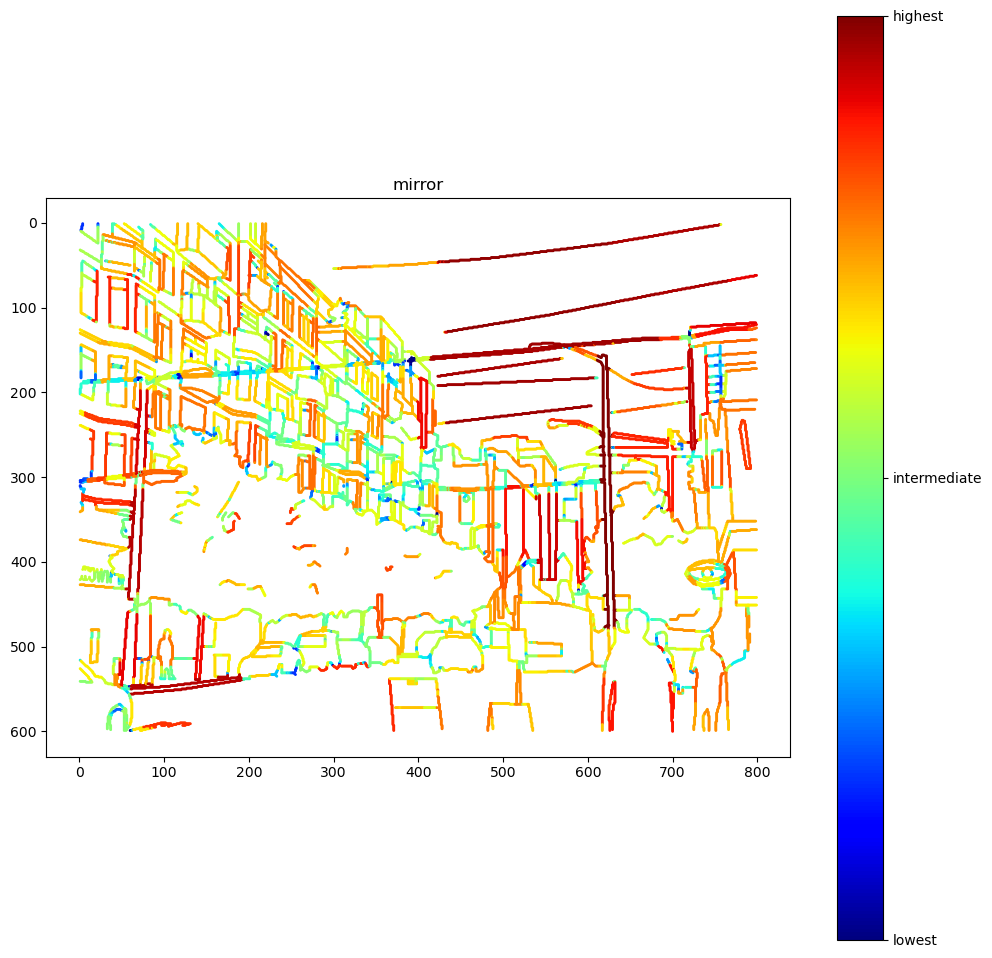

parallelism


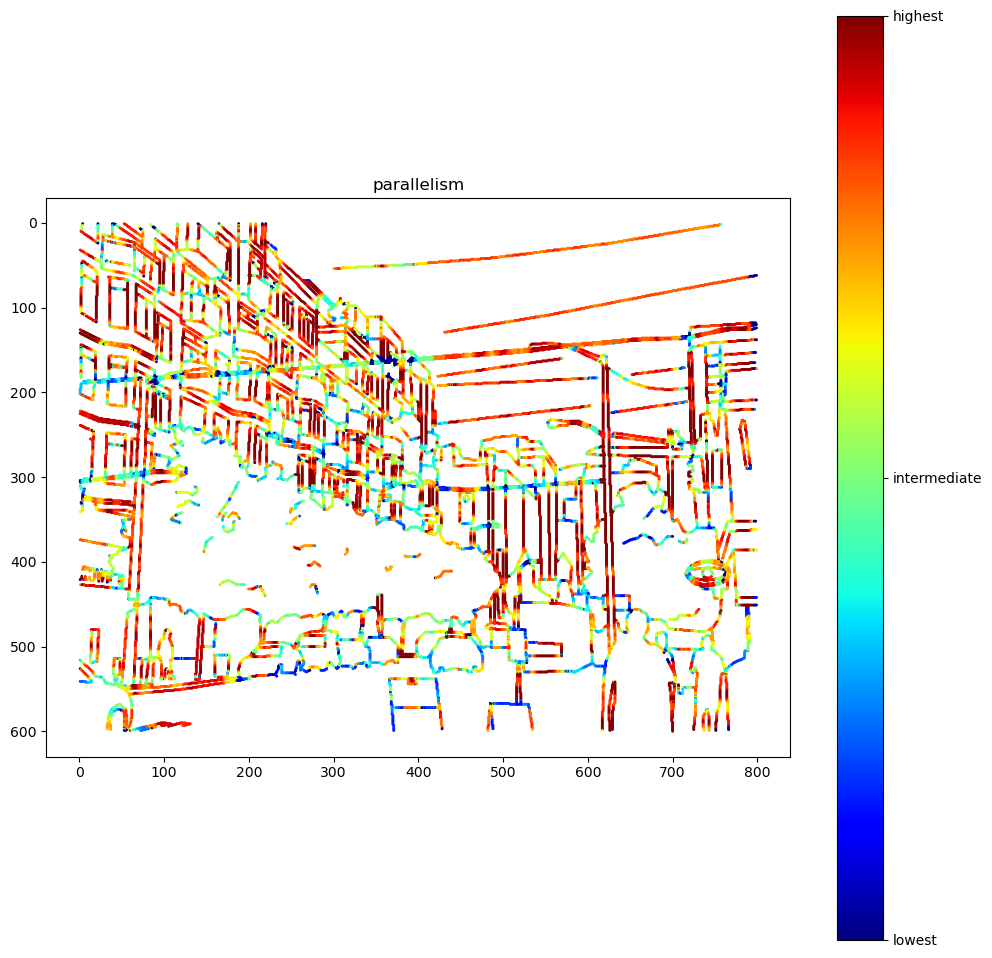

separation


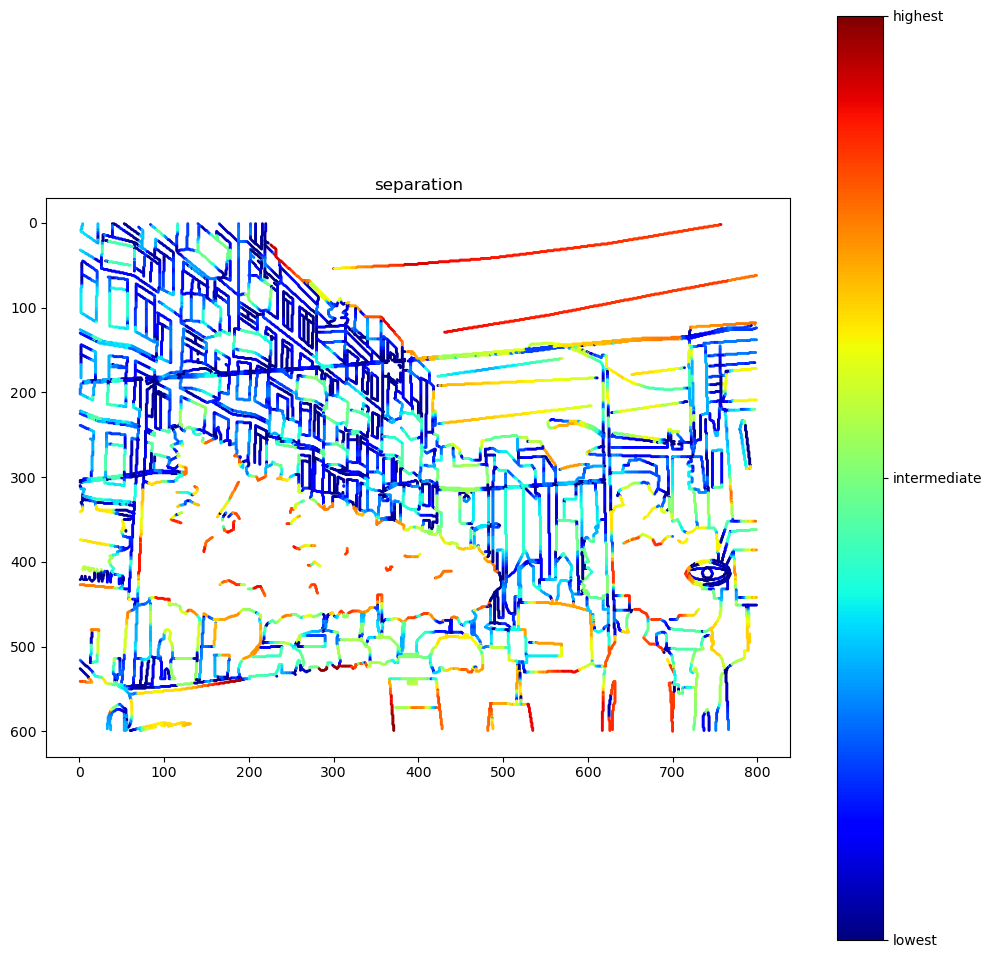

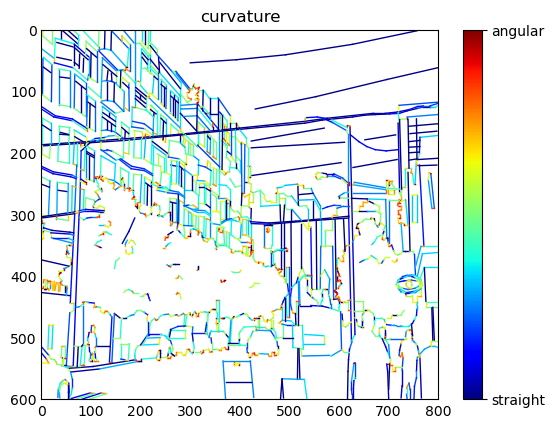

In [15]:
drawAllProperties(temp_ld, 'subplot', ['original','orientation','length','junctions',
                                    'mirror','parallelism','separation', 'curvature'])

# Stats calculation

In [16]:
# Get a copy of cute 
temp_cute = cute.copy()

In [17]:
from getOrientationStats import getOrientationStats
from getLengthStats import getLengthStats
from getCurvatureStats import getCurvatureStats
from getHorizontalVerticalStats import getHorizontalVerticalStats
# Need to fix junctions
# from getJunctionStats import getJunctionStats

# Need to fix junctions
# from getContourPropertiesStats import getContourPropertiesStats

In [18]:
# def getJunctionStats(vecLD,
#                      numAngleBins = 8,
#                      junctionTypes = ['T', 'Y', 'X', 'Arrow', 'Star']):
#     # Need to fix the junction angles
#     if 'junctions' not in vecLD:
#         vecLD = computeJunctions(vecLD)

#     if len(vecLD['junctions'][0].shape) == 0:
#         vecLD['junctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
#                                                        len(junctionTypes)))
#         vecLD['normJuctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
#                                                                 len(junctionTypes)))
#         vecLD['junctionTypeHistogram'] = np.zeros(len(junctionTypes))
#         vecLD['normJunctionTypeHistogram'] = np.zeros(len(junctionTypes))
#     else:
#         these_types = [j['type'] for j in vecLD['junctions']]
#         type_hist = np.zeros(len(junctionTypes))
#         vecLD['junctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
#                                                          len(junctionTypes)))
#         for t, jt in enumerate(junctionTypes):
#             this_j = []
#             for j_type in these_types[0]:
#                 if j_type == jt:
#                     this_j.append(1)
#                 else:
#                     this_j.append(0)
            
#             type_hist[t] = np.sum(this_j)
#             contours = []
#             for i in range(len(vecLD['junctions'][0])):
#                 if this_j[i] == 1:
#                     contours.append(vecLD['junctions'][0]['contourIDs'][i])
#             # print("Size of contours: ", len(contours))
#             contours = [item for sublist in contours for sublist_item in sublist for item in sublist_item]
#             for c in np.unique(contours):
#                 vecLD['junctionContourHistograms'][c-1,t] = np.sum(np.array(contours) == c)
#             vecLD['normJunctionContourHistograms'] = (
#                 vecLD['junctionContourHistograms'] / np.tile(vecLD['contourLengths'], (len(junctionTypes))) * 10000
#             )
#             vecLD['junctionTypeHistogram'] = type_hist
#             vecLD['normJunctionTypeHistogram'] = type_hist / np.sum(vecLD['contourLengths']) * 10000

#     vecLD['junctionTypeBins'] = junctionTypes

#     # Junction Angles - Histogram needs to be fixed
#     maxAngle = 120
#     binStep = maxAngle / numAngleBins
#     angleBins = np.arange(binStep/2, maxAngle, binStep)
#     if len(vecLD['junctions'][0].shape) == 0:
#         print("IF")
#         vecLD['junctionAngleHistogram'] = np.zeros(len(junctionTypes))
#         vecLD['normJunctionAngleHistogram'] = np.zeros(len(junctionTypes))
#         histograms = [np.array([]), np.array([])]
#     else:
#         print("ELSE")
#         angles = vecLD['junctions']['minAngle'][0]
#         # for j in vecLD['junctions']:
#         #     angles.append(j['minAngle'])
#         # angles = np.array([j['minAngle'] for j in vecLD['junctions']])
#         print("Length of angles: ", angles.shape)
#         # print(angles)
#         angleHist, _ = np.histogram(angles, bins=angleBins)
#         print("Bins of angle hist: ", angleBins)
#         print("Angle Hist: ", angleHist)
#         print("Length of angle hist: ", len(angleHist))
#         vecLD['junctionAngleHistogram'] = angleHist
#         vecLD['normJunctionAngleHistogram'] = angleHist / np.sum(vecLD['contourLengths']) * 10000
#         histograms = [type_hist, angleHist]

#     vecLD['junctionAngleBins'] = angleBins

#     bins = [junctionTypes, angleBins]
#     shortNames = ['juncType', 'juncAngle']

#     return vecLD, histograms, bins, shortNames

In [19]:
# def getContourPropertiesStats(vecLD, minmaxLen=[], 
#                                 whichStats=['orientation',
#                                                  'length',
#                                                  'curvature',
#                                                  'junctions'], 
#                                 minmaxCurv=[],
#                                 junctionTypes=[]):
#     numBins = 8
#     histograms = []
#     bins = []
#     statsNames = []
#     for i in range(len(whichStats)):
#         thisStat = whichStats[i].lower()
#         if thisStat == 'orientation':
#             vecLD, next_hist, next_bins, next_stat = getOrientationStats(vecLD, numBins)
#             histograms.append(next_hist)
#             bins.append(next_bins)
#             statsNames.append(next_stat)
#         elif thisStat == 'horver':
#             vecLD, next_hist, next_bins, next_stat = getHorizontalVerticalStats(vecLD, numBins)
#             histograms.append(next_hist)
#             bins.append(next_bins)
#             statsNames.append(next_stat)
#         elif thisStat == 'length':
#             if len(minmaxLen)==0:
#                 vecLD, next_hist, next_bins, next_stat = getLengthStats(vecLD,
#                                                                             numBins)
#             else:
#                 vecLD, next_hist, next_bins, next_stat = getLengthStats(vecLD,
#                                                                             numBins,
#                                                                             minmaxLen)
#             histograms.append(next_hist)
#             bins.append(next_bins)
#             statsNames.append(next_stat)
#         elif thisStat == 'curvature':
#             if len(minmaxCurv)==0:
#                 vecLD, next_hist, next_bins, next_stat = getCurvatureStats(vecLD,
#                                                                                numBins)
#             else:
#                 vecLD, next_hist, next_bins, next_stat = getCurvatureStats(vecLD,
#                                                                                numBins,
#                                                                                minmaxCurv)
#             histograms.append(next_hist)
#             bins.append(next_bins)
#             statsNames.append(next_stat)
#         elif thisStat == 'junctions':
#             if len(junctionTypes)==0:
#                 vecLD, jHist, jBins, jNames = getJunctionStats(vecLD, numBins)
#             else:
#                 vecLD, jHist, jBins, jNames = getJunctionStats(vecLD, numBins, junctionTypes)
#             histograms.append(jHist)
#             bins.append(jBins)
#             statsNames.append(jNames)
#         else:
#             warnings.warn('Unknown property: ' + thisStat)

#     return vecLD,histograms,bins,statsNames

In [21]:
temp_cute = cute.copy()
temp_cute,histograms,bins,statsNames = getContourPropertiesStats(temp_cute, whichStats=['curvature','length','orientation'])

In [22]:
# Get contour properties histograms
cute,histograms,bins,statsNames = getContourPropertiesStats(cute)

ELSE
Length of angles:  (480,)
Bins of angle hist:  [  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5]
Angle Hist:  [ 18  23  86  99  71 153   7]
Length of angle hist:  7


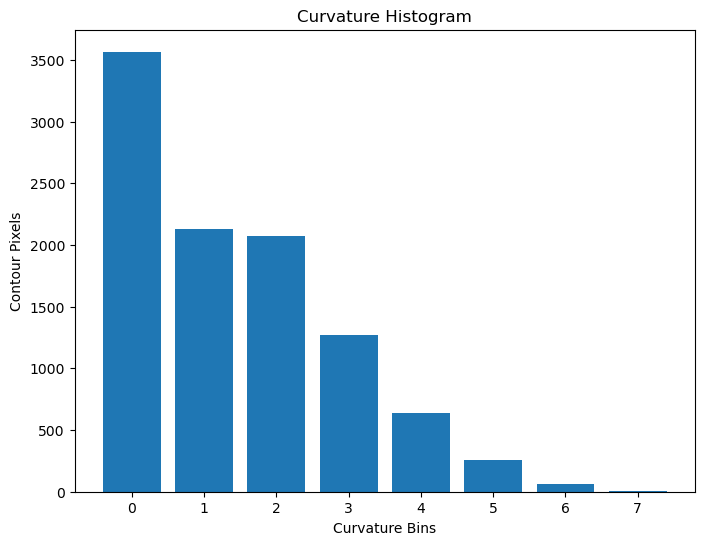

In [24]:
# Plot histogram of cute['normSumCurvatureHistogram'] using plot
plt.figure(figsize=(8,6))
plt.bar(range(len(cute['normSumCurvatureHistogram'])), cute['normSumCurvatureHistogram'])
plt.title('Curvature Histogram')
plt.xlabel('Curvature Bins')
plt.ylabel('Contour Pixels')
plt.show()

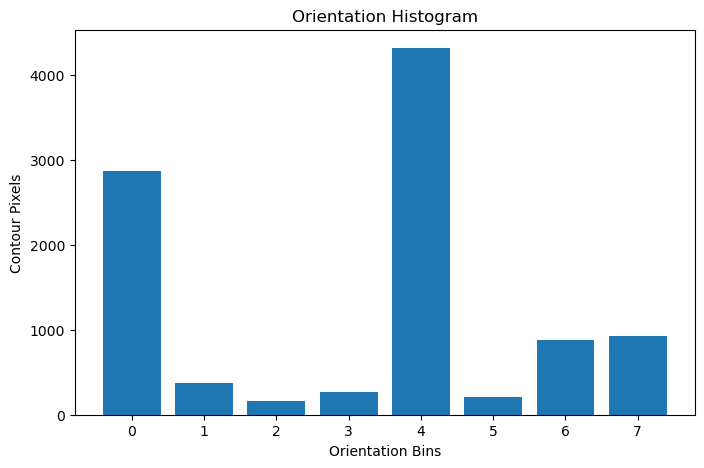

In [25]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normSumOrientationHistogram'])), cute['normSumOrientationHistogram'])
plt.title('Orientation Histogram')
plt.xlabel('Orientation Bins')
plt.ylabel('Contour Pixels')
plt.show()

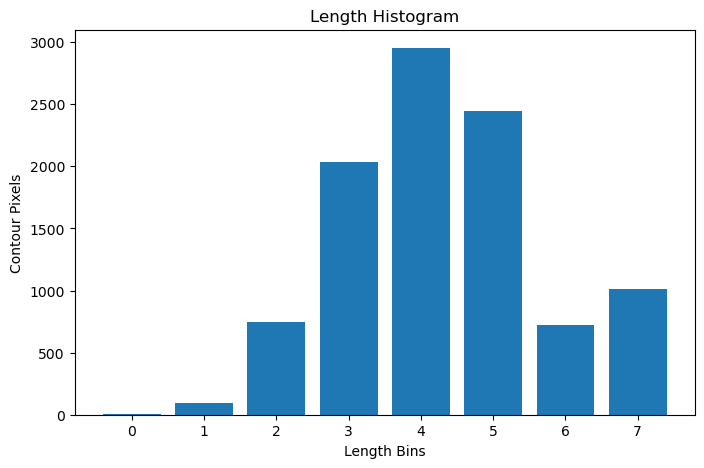

In [26]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normSumLengthHistogram'])), cute['normSumLengthHistogram'])
plt.title('Length Histogram')
plt.xlabel('Length Bins')
plt.ylabel('Contour Pixels')
plt.show()

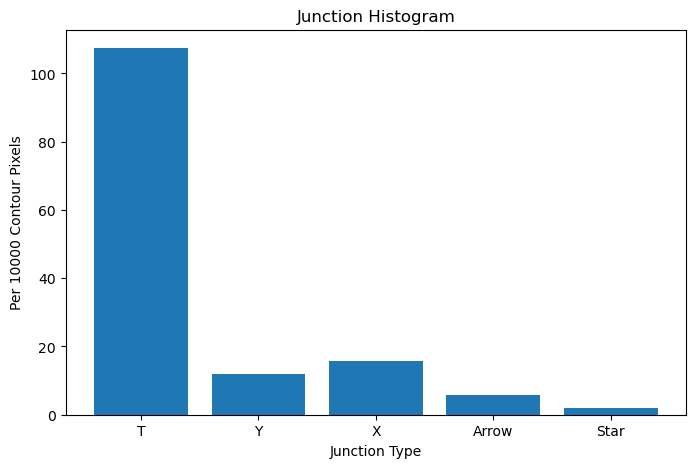

In [27]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normJunctionTypeHistogram'])), cute['normJunctionTypeHistogram'])
plt.title('Junction Histogram')
plt.xlabel('Junction Type')
plt.xticks(range(len(cute['junctionTypeBins'])), cute['junctionTypeBins'])
plt.ylabel('Per 10000 Contour Pixels')
plt.show()

## Split functions

In [29]:
from MLVcode.splitLDbyProperties import splitLDbyProperties

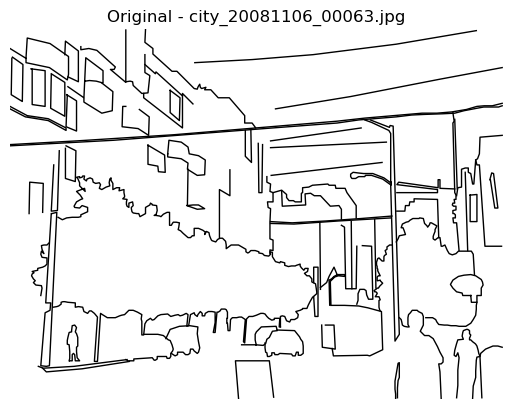

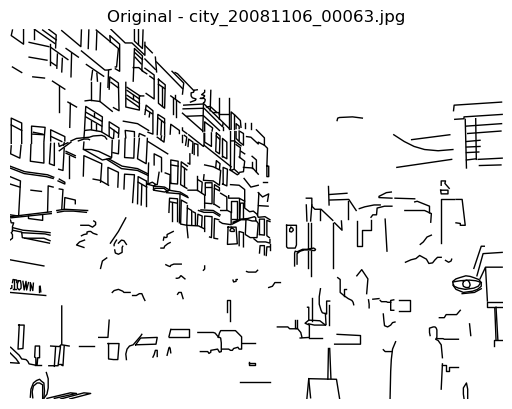

In [30]:
# Split image into two versions based on selected properties
# Split image by curvature and orientation (50% proportion of pixels)
top,bottom = splitLDbyProperties(cute,['length'])
drawLinedrawing(top)
drawLinedrawing(bottom)

In [31]:
cute['contourLengths'].shape

(476, 1)

Top:
Bottom:


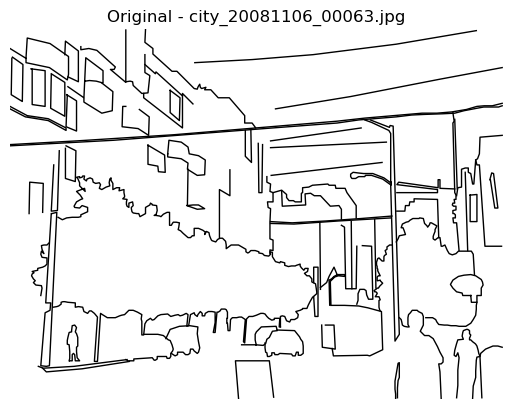

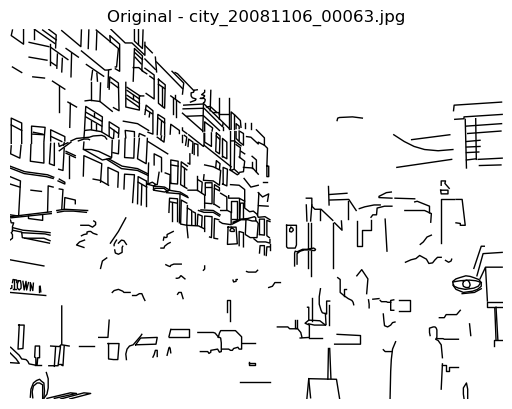

In [32]:
top, bottom = splitLDbyProperties(cute, ['length'], 0.5)
print("Top:")
drawLinedrawing(top)
print("Bottom:")
drawLinedrawing(bottom)

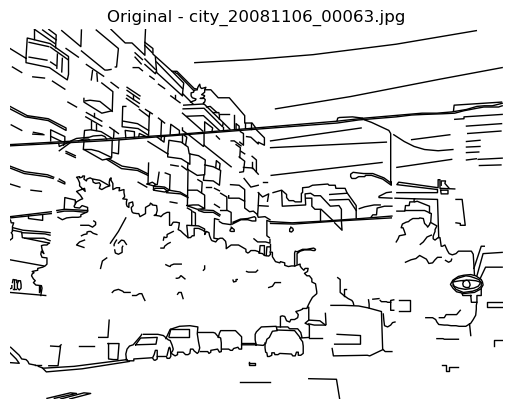

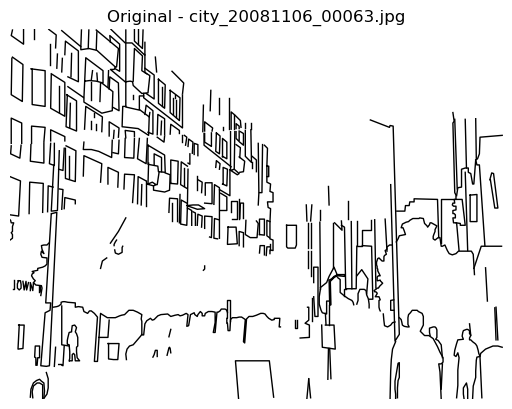

In [37]:
top, bottom = splitLDbyProperties(cute, ['orientation'],fraction=0.550)
drawLinedrawing(top)
drawLinedrawing(bottom)

No lengths in vecLD
No orientations in vecLD
No lengths in vecLD
No orientations in vecLD


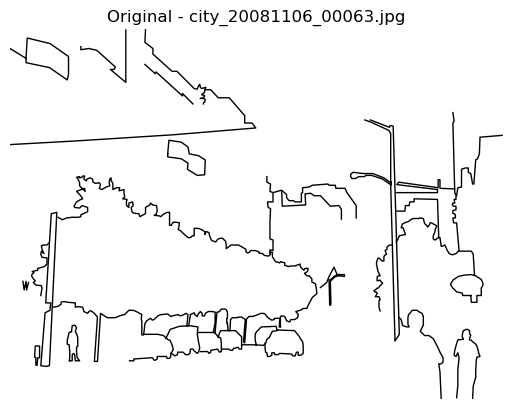

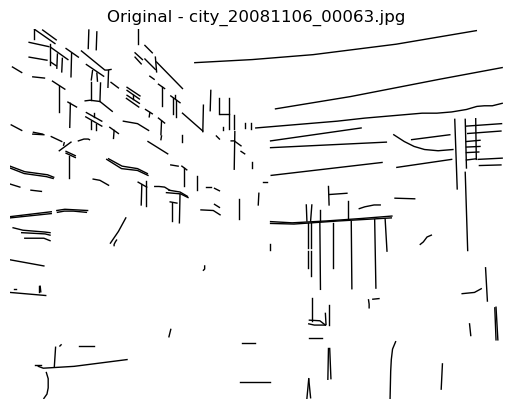

In [38]:
# THere is some error which comes when I type 0.15. Check that later
top, bottom = splitLDbyProperties(cute, ['curvature'],fraction=0.25)
drawLinedrawing(top)
drawLinedrawing(bottom)